In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

In [15]:
# Define training transformations with data augmentation
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Normalize(mean=(0,), std=(1,)),
    ToTensorV2()
])

# Define validation transformations (no augmentation)
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0,), std=(1,)),
    ToTensorV2()
])

# Dataset class
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        # Get sorted images and masks
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

        # Ensure images and masks match
        self.images = [img for img in self.images if img.replace("_cropped_gray.jpg", "_mask.png") in self.masks]
        self.masks = [mask for mask in self.masks if mask.replace("_mask.png", "_cropped_gray.jpg") in self.images]

        print(f"Found {len(self.images)} images and {len(self.masks)} masks in {images_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        # Load grayscale image and convert to RGB
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        """image = np.expand_dims(image, axis=-1)  # (H, W) → (H, W, 1)
        image = np.repeat(image, 3, axis=-1)  # Convert grayscale to 3-channel RGB"""

        # Load mask in grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Convert mask to binary (0,1)
        mask = (mask > 0).astype(np.uint8)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Convert mask to tensor
        if isinstance(mask, np.ndarray):
          mask = torch.from_numpy(mask).float().unsqueeze(0)  # Convert to tensor if it's still a NumPy array
        else:
          mask = mask.float().unsqueeze(0)  # If it's already a tensor, just ensure it's float and unsqueeze


        return image, mask

In [16]:
# Define dataset paths
dataset_dir = "/content/drive/MyDrive/Projet_echo"
train_images_dir = os.path.join(dataset_dir, "train/images")
train_masks_dir = os.path.join(dataset_dir, "train/masks")
val_images_dir = os.path.join(dataset_dir, "val/images")
val_masks_dir = os.path.join(dataset_dir, "val/masks")

# Create dataset instances
train_dataset = SegmentationDataset(train_images_dir, train_masks_dir, transform=train_transform)
val_dataset = SegmentationDataset(val_images_dir, val_masks_dir, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

Found 327 images and 327 masks in /content/drive/MyDrive/Projet_echo/train/images
Found 93 images and 93 masks in /content/drive/MyDrive/Projet_echo/val/images


In [17]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define U-Net model with ResNet-50 encoder
model = smp.Unet(
    encoder_name="vgg16",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,  # Binary segmentation
).to(device)

# Define loss function (Dice Loss)
loss_fn = smp.losses.DiceLoss(mode="binary")

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

print("Model, loss function, optimizer, and scheduler initialized")

Using device: cuda
Model, loss function, optimizer, and scheduler initialized


In [18]:
def evaluate_loss(model, val_loader, loss_fn):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.float().to(device)  # Ensure float dtype
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    return val_loss / len(val_loader)  # Return average validation loss


def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs=20):
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.float().to(device)  # Ensure float dtype for loss calculation

            optimizer.zero_grad()
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, masks)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Evaluate on validation set
        val_loss = evaluate_loss(model, val_loader, loss_fn)

        # Step scheduler
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "/content/drive/MyDrive/Projet_echo/unet_vgg16.pth")
            print("Saved new best model")

In [19]:
train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs=30)

Epoch 1/30 | Train Loss: 0.4927 | Val Loss: 0.3856
Saved new best model
Epoch 2/30 | Train Loss: 0.3531 | Val Loss: 0.3511
Saved new best model
Epoch 3/30 | Train Loss: 0.3080 | Val Loss: 0.2924
Saved new best model
Epoch 4/30 | Train Loss: 0.2731 | Val Loss: 0.2505
Saved new best model
Epoch 5/30 | Train Loss: 0.2483 | Val Loss: 0.2301
Saved new best model
Epoch 6/30 | Train Loss: 0.2251 | Val Loss: 0.2512
Epoch 7/30 | Train Loss: 0.2068 | Val Loss: 0.1880
Saved new best model
Epoch 8/30 | Train Loss: 0.1838 | Val Loss: 0.1726
Saved new best model
Epoch 9/30 | Train Loss: 0.1708 | Val Loss: 0.1667
Saved new best model
Epoch 10/30 | Train Loss: 0.1623 | Val Loss: 0.1821
Epoch 11/30 | Train Loss: 0.1555 | Val Loss: 0.1414
Saved new best model
Epoch 12/30 | Train Loss: 0.1484 | Val Loss: 0.1346
Saved new best model
Epoch 13/30 | Train Loss: 0.1441 | Val Loss: 0.1475
Epoch 14/30 | Train Loss: 0.1316 | Val Loss: 0.1267
Saved new best model
Epoch 15/30 | Train Loss: 0.1284 | Val Loss: 0.119

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from segmentation_models_pytorch.utils.metrics import IoU, Fscore

# Define IoU and Dice Score metrics
iou_metric = IoU(threshold=0.5)
dice_metric = Fscore(threshold=0.5, beta=1.0)

def evaluate_model(model, data_loader, device):
    """
    Evaluates the model using IoU and Dice Score.
    """
    model.to(device)
    model.eval()

    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)

            # Ensure masks are float for correct loss computation
            masks = masks.float()

            # Get model predictions
            outputs = model(images)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid activation
            outputs = (outputs > 0.5).float()  # Convert to binary mask

            # Compute IoU and Dice Score correctly
            iou_scores.append(iou_metric(outputs, masks).cpu().numpy().astype(np.float32))
            dice_scores.append(dice_metric(outputs, masks).cpu().numpy().astype(np.float32))

    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)

    print(f"\nModel Evaluation Completed!")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice Score: {mean_dice:.4f}")

    return mean_iou, mean_dice

In [24]:
# Load the trained model
model_path = "/content/drive/MyDrive/Projet_echo/unet_vgg16.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="vgg16",
    encoder_weights=None,
    in_channels=1,
    classes=1,  # Binary segmentation
).to(device)

# Load model weights
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()  # Set the model to evaluation mode

print(" Model loaded")

 Model loaded


In [ ]:
mean_iou, mean_dice = evaluate_model(model, val_loader, device)


Model Evaluation Completed!
Mean IoU: 0.7028
Mean Dice Score: 0.8246


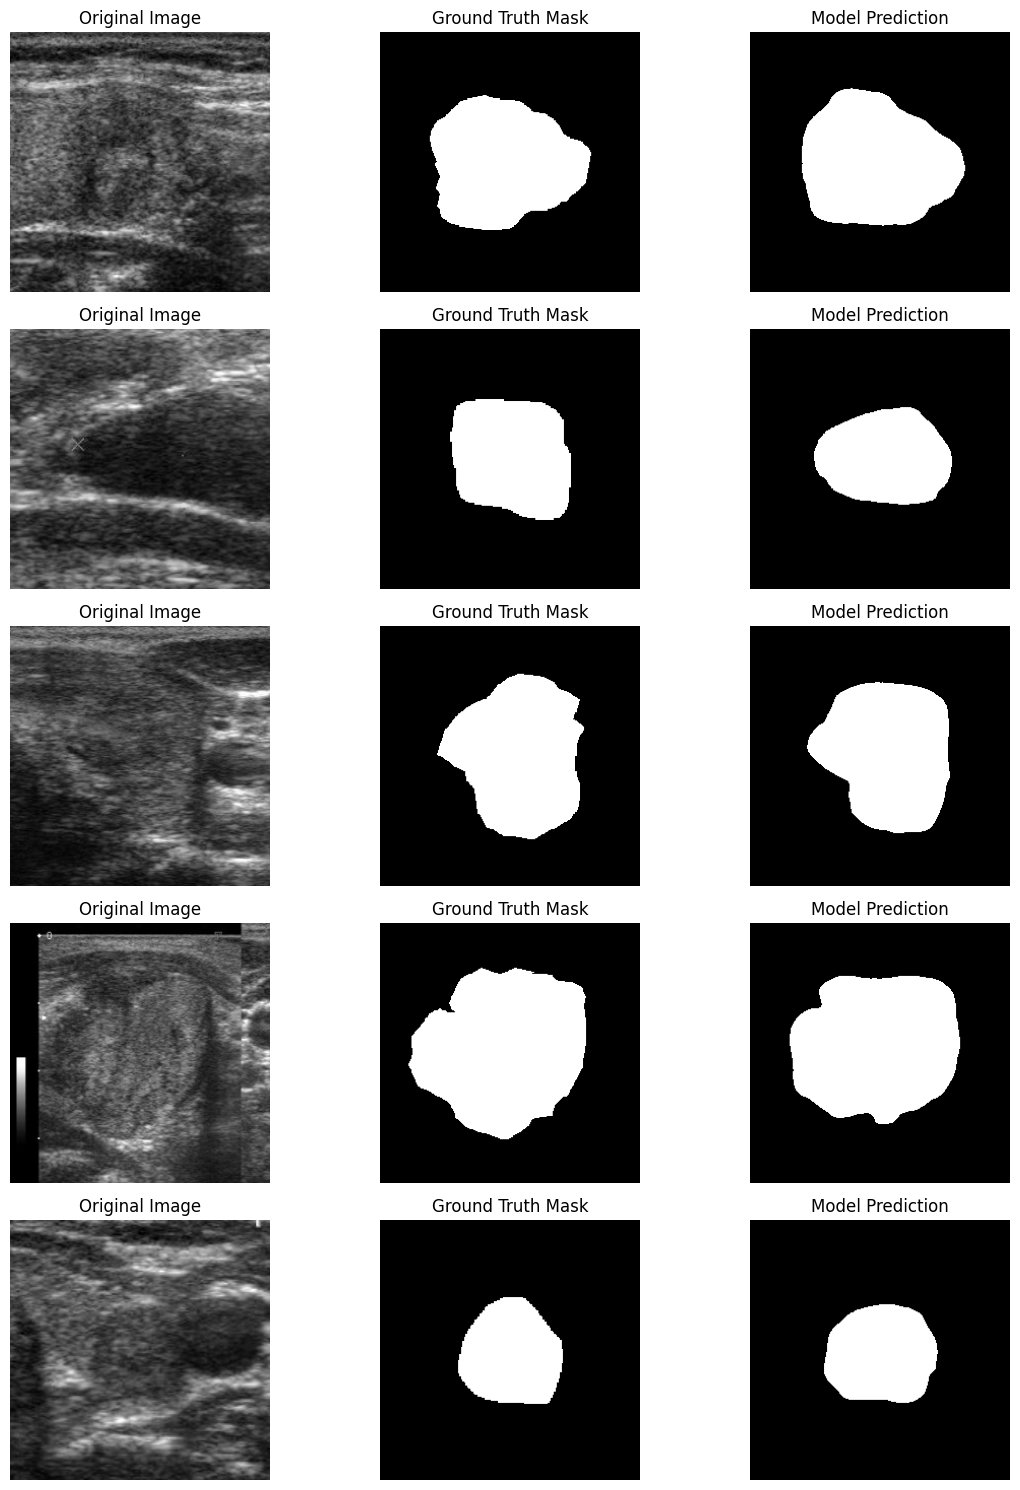

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, num_samples=5):
    """
    Displays sample images with ground truth and predicted masks.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))

    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))  # Select a random index
        image, mask = dataset[idx]

        # Convert to batch format
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image)
            output = torch.sigmoid(output)
            output = (output > 0.5).float().cpu().numpy()[0, 0]  # Convert to binary mask

        # Convert image tensor to numpy format
        image = image.cpu().numpy()[0].transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
        mask = mask.cpu().numpy()[0]  # (1, H, W) → (H, W)

        # Plot images
        axes[i, 0].imshow(image, cmap="gray")
        axes[i, 0].set_title("Original Image")
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 2].imshow(output, cmap="gray")
        axes[i, 2].set_title("Model Prediction")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_predictions(model, val_dataset, num_samples=5)